<a href="https://colab.research.google.com/github/lrodrigocareaga/thesis/blob/master/MosquitoHybridModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
#General libraries needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
import keras,os,tarfile,sys,pickle,zipfile

#Keras libraries & packages
from keras import models,initializers,layers,optimizers
from keras import backend as K
from keras.utils import to_categorical,plot_model
from keras.models import Sequential,Model, load_model
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input,Dense,Conv2D,advanced_activations,Flatten,concatenate,Dropout,MaxPooling2D,Activation,GlobalAveragePooling2D,BatchNormalization,SeparableConv2D,SpatialDropout2D,LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input

#Sci-kit libraries
from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import train_test_split,StratifiedKFold, KFold, ShuffleSplit
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, MultiLabelBinarizer, LabelEncoder
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.datasets import make_regression

#Others
import time
import matplotlib.image as mpimg
import skimage
import argparse
import locale
import glob
import sklearn.model_selection
import cv2
import shapely.wkt
import shapely.affinity
import seaborn as sns
from skimage.io import imshow
from shapely.geometry import MultiPolygon, Polygon
from collections import defaultdict
from shapely.wkt import loads as wkt_loads

Using TensorFlow backend.


In [2]:
# Establish the home directory
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/mosquito')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
tbc=TensorBoardColab()
import warnings
warnings.filterwarnings('ignore')

Wait for 8 seconds...
TensorBoard link:
http://28149406.ngrok.io


# Experiments

## Load Data


In [0]:
def loadData(fileXls):

  #Numerical and Categorical columns needed in the data
  cols = ['collection_date','GPS_lat','GPS_lon','species','day','month','year','sample_count']

  #Source file
  df_info = pd.read_excel(fileXls)
  #Erase blank rows
  df_info = df_info.dropna()

  #Add year and month
  df_info['year'] = df_info['collection_date'].dt.year.astype(int)
  df_info['month'] = df_info['collection_date'].dt.month.astype(int)
  df_info['day'] = df_info['collection_date'].dt.day.astype(int)

  #filter the dataset
  df = df_info[cols]
  df = df.dropna()

  df['GENUS'] = df['species'].str.split(' ').str[0].astype(str)
  df['SPECIES'] = df['species'].str.split(' ').str[1].astype(str)
  df = df.rename(columns={"GPS_lat": "LATITUDE", "GPS_lon": "LONGITUDE"})

  df.sample_count = df.sample_count.astype(int)
  df['date'] = pd.to_datetime(df['collection_date'].dt.strftime('%d-%m-%Y'))

  del df['collection_date']
  del df['species']

  return df

In [0]:
fileXls = '/content/drive/My Drive/mosquito/Manatee.xlsx'
df = loadData(fileXls)

In [0]:
#Count of mosquitos trapped by ovitrap
def printInfo(df):
  countMonthK = df["month"].value_counts().keys().tolist()
  countMonth = df["month"].value_counts().tolist()
  print('Number of mosquitos captured by Month: ' + str(countMonthK))
  print('Number of mosquitos captured by Month: ' + str(countMonth))

  countYearK = df["year"].value_counts().keys().tolist()
  countYear = df["year"].value_counts().tolist()
  print('Number of mosquitos captured by Year: ' + str(countYearK))
  print('Number of mosquitos captured by Year: ' + str(countYear))

  countGenusK = df["GENUS"].value_counts().keys().tolist()
  countGenus = df["GENUS"].value_counts().tolist()
  print('Number of mosquitos captured by Genus: ' + str(countGenusK))
  print('Number of mosquitos captured by Genus: ' + str(countGenus))

  #DataFrame of number of mosquitos by trap
  traps_df = pd.DataFrame({'Genus' : countGenusK,
                         'Total' : countGenus},
                         columns=['Genus','Total'])

  print(traps_df.head())
  return 

In [7]:
printInfo(df)

Number of mosquitos captured by Month: [8, 7, 6, 9, 10, 5, 11, 4, 12, 3, 2, 1]
Number of mosquitos captured by Month: [11109, 10999, 10887, 10429, 9977, 5500, 3564, 960, 636, 271, 26, 11]
Number of mosquitos captured by Year: [2014, 2013, 2016, 2015, 2012, 2002]
Number of mosquitos captured by Year: [14741, 13073, 12847, 12815, 10848, 45]
Number of mosquitos captured by Genus: ['Culex', 'Aedes', 'Anopheles', 'Psorophora', 'Mansonia', 'Coquillettidia', 'Uranotaenia', 'Culiseta', 'Wyeomyia', 'BLANK', 'Culicidae', 'Culicinae', 'Orthopodomyia']
Number of mosquitos captured by Genus: [22141, 12123, 11354, 9567, 5542, 1605, 1250, 520, 108, 78, 72, 6, 3]
        Genus  Total
0       Culex  22141
1       Aedes  12123
2   Anopheles  11354
3  Psorophora   9567
4    Mansonia   5542


In [0]:
#dataset of Washington Climate
def loadDataClimate(fileXlsClimate):

  df_climate = pd.read_excel(fileXlsClimate)

  df_climate['LATITUDE'] = df_climate['coordinates'].str.split(';').str[0].astype(float)
  df_climate['LONGITUDE'] = df_climate['coordinates'].str.split(';').str[1].astype(float)
  
  df_climate['date'] =  pd.to_datetime(df_climate['date'], format='%Y-%m-%d')
  df_climate['year'] = df_climate['date'].dt.year.astype(int)
  df_climate['month'] = df_climate['date'].dt.month.astype(int)
  df_climate['day'] = df_climate['date'].dt.day.astype(int)
  
  return df_climate


In [0]:
#fileXlsClimate = '/content/drive/My Drive/mosquito/weatherWashington.xlsx'
fileXlsClimate = '/content/drive/My Drive/mosquito/WeatherManateeFinal.xlsx'
df_climate = loadDataClimate(fileXlsClimate)

In [0]:
#Merge of climate and mosquitos dataset
def mergeDatasets(df, df_climate):
  result = pd.merge(df, df_climate, how='inner', on=['year','month','day','LATITUDE','LONGITUDE'])
  result.head()

  #Export dataset to csv
  result.to_csv('result.csv',index=True)
  del result['date_x']
  del result['coordinates']
  result = result.rename(columns={"sample_count": "TOTAL", "date_y": "date"}) 
  result.TOTAL = result.TOTAL.astype(int)

  return result

In [11]:
result = mergeDatasets(df, df_climate)
print(result.head())
print(result.info())

    LATITUDE  LONGITUDE  day  ...  humidity  windSpeed  cloudCover
0  27.516317 -82.537735   22  ...      0.78       2.16        0.45
1  27.516317 -82.537735   22  ...      0.78       2.16        0.45
2  27.554018 -82.545481   22  ...      0.78       2.15        0.44
3  27.488870 -82.592140   22  ...      0.79       2.25        0.44
4  27.439449 -82.548928   22  ...      0.80       2.36        0.40

[5 rows x 20 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 64332 entries, 0 to 64331
Data columns (total 20 columns):
LATITUDE              64332 non-null float64
LONGITUDE             64332 non-null float64
day                   64332 non-null int64
month                 64332 non-null int64
year                  64332 non-null int64
TOTAL                 64332 non-null int64
GENUS                 64332 non-null object
SPECIES               64332 non-null object
date                  64332 non-null datetime64[ns]
precipType            64332 non-null int64
precipProbability    

In [0]:
result['location'] = result['LATITUDE'].astype(str) + '_' + result['LONGITUDE'].astype(str)

In [0]:
dfImages = pd.read_excel('imagesManatee.xlsx', sheet_name='Sheet1')
dfImages.head()
result = pd.merge(result, dfImages, how='inner', on='LATITUDE')

In [0]:
def takeOutliers(result, percentile):
  result  = result.sort_values(by=['TOTAL'])
  numEntries = len(result.index)
  lowerBound = round(((1-percentile)/2),3)
  upperBound = 1-lowerBound
  print(lowerBound,' and ',upperBound)
  result = result.iloc[int((numEntries*lowerBound)):(int(numEntries*upperBound))]
  result.reindex(np.random.permutation(result.index))
  return result

In [16]:
result = takeOutliers(result, 0.90)
print(result.head())
print(result.info())

0.05  and  0.95
       LATITUDE  ...                                  fileName
9016  27.481256  ...  27.481256_-82.48042_April_2015_500ft.png
9014  27.481256  ...  27.481256_-82.48042_April_2015_500ft.png
8766  27.481256  ...  27.481256_-82.48042_April_2015_500ft.png
8868  27.481256  ...  27.481256_-82.48042_April_2015_500ft.png
8816  27.481256  ...  27.481256_-82.48042_April_2015_500ft.png

[5 rows x 22 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 35106 entries, 9016 to 5347
Data columns (total 22 columns):
LATITUDE              35106 non-null float64
LONGITUDE             35106 non-null float64
day                   35106 non-null int64
month                 35106 non-null int64
year                  35106 non-null int64
TOTAL                 35106 non-null int64
GENUS                 35106 non-null object
SPECIES               35106 non-null object
date                  35106 non-null datetime64[ns]
precipType            35106 non-null int64
precipProbability     35106

## Visualization & data split

In [0]:
def boxPlotFunc(result):
  plt.plot()
  sns.boxplot(x='GENUS',y='TOTAL',data=result)
  plt.xlabel('GENUS')
  plt.ylabel('TOTAL')
  plt.title('Boxplot Graph')
  plt.savefig('box_Overall_Year.eps', format='eps', dpi=900)
  return plt.show()

In [0]:
def violinPlotFunc(result):
  sns.violinplot(x='GENUS',y='TOTAL',data=result,inner=None,color='lightgray')
  sns.stripplot(x='GENUS',y='TOTAL',data=result,size=10,jitter=True)
  plt.xlabel('TOTAL')
  plt.ylabel('Overall')
  plt.title('Violin Graph')
  plt.tight_layout()
  plt.savefig('viol_Overall_Year.eps', format='eps', dpi=900)
  return plt.show()

In [0]:
#Observe the correlation of the variables
def corrPlotFunc(result):
  corr = result.corr()
  corr.style.background_gradient()

  sns.heatmap(corr, cmap="RdYlGn_r", square= True, vmin=-1, vmax=1)
  plt.savefig('corr.eps', format='eps', dpi=900)
  # Display the heatmap
  return plt.show()

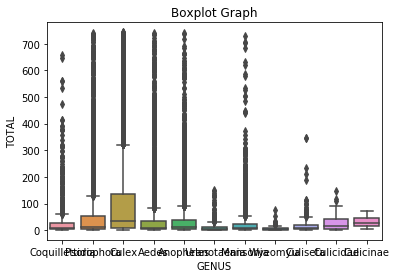

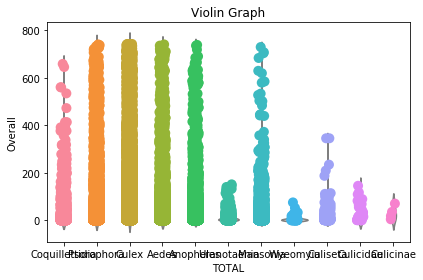

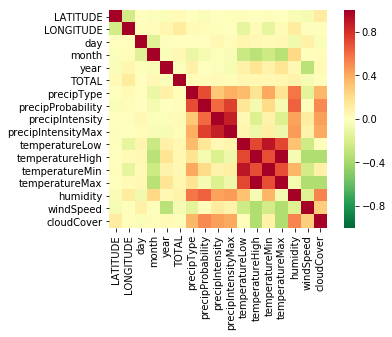

In [20]:
boxPlotFunc(result)
violinPlotFunc(result)
corrPlotFunc(result)

In [0]:
def xyFunc(result):
  del result['date']
  del result['location']
  del result['fileName']

  X = result.iloc[:, :].values
  y = result.iloc[:, 5].values

  # Transform categorical variables if needed
  labelencoder = LabelEncoder()
  X[:, 6] = labelencoder.fit_transform(X[:, 6])
  X[:, 7] = labelencoder.fit_transform(X[:, 7])
  X[:, -1] = labelencoder.fit_transform(X[:, -1])
  scaler = MinMaxScaler(feature_range=(0, 1))
  X = scaler.fit_transform(X)

  return X,y

In [0]:
X,y = xyFunc(result)

## SVM

In [0]:
# function to print SVM
def svmFunct(X,y):
  scoresCoef = []
  regrSVM = LinearSVR(random_state=0, tol=1e-5)
  cv = KFold(n_splits=10, random_state=1, shuffle=True)

  for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    regrSVM.fit(X_train, y_train)
    y_pred = regrSVM.predict(X_test)
      
  print(regrSVM.coef_)
  print(regrSVM.intercept_)

  
  fig, ax = plt.subplots()
  ax.scatter(y_test, y_pred)
  ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
  ax.set_xlabel('True Values')
  ax.set_ylabel('Predicted')
  plt.savefig('SVM.eps', format='eps', dpi=900)

  return plt.show()

[-1.77912359e-05  9.43453732e-06 -7.32349217e-07  5.03121491e-05
 -4.26657798e-05  7.42000021e+02  1.86007461e-05  3.07930272e-06
 -4.20689384e-05  2.29003765e-06 -4.43209063e-04  5.59475768e-05
  2.61958404e-04 -1.83371841e-02 -4.08399443e-04  1.70818409e-02
 -1.52862607e-05 -1.74275140e-04  1.89454505e-04]
[1.00141748]


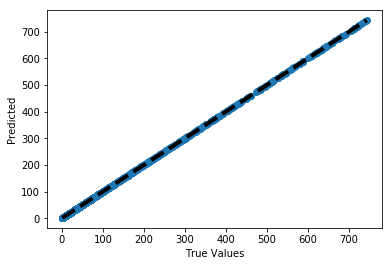

In [25]:
svmFunct(X,y)

## Linear Regression

In [0]:
def linearRegressionFunct(X,y):
  scoresCoef = []
  linreg = LinearRegression()
  cv = KFold(n_splits=10, random_state=1, shuffle=True)

  for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
  
  print('Accuracy of linear regression classifier on test set: {:.2f}'.format(linreg.score(X_test,y_test)))
  #print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(linreg.score(testX, testY))
  print(linreg.coef_)
  print(linreg.intercept_)

  
  fig, ax = plt.subplots()
  ax.scatter(y_test, y_pred)
  ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
  ax.set_xlabel('True Values')
  ax.set_ylabel('Predicted')
  plt.savefig('linreg.eps', format='eps', dpi=900)

  return plt.show()

Accuracy of linear regression classifier on test set: 1.00
[-2.36250574e-14 -1.56319402e-13  1.63410386e-13  6.03264217e-14
  5.59101825e-14  7.42000000e+02  2.11058932e-14 -7.39857134e-14
 -2.09698816e-13 -4.51123473e-14  3.45842158e-13 -4.10845575e-13
  2.80182687e-13  2.41028498e-12  7.17176033e-14 -1.90414351e-12
  8.07191368e-13 -3.55715457e-13  4.63629135e-13]
0.9999999999983729


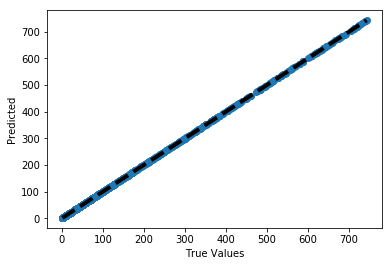

In [27]:
linearRegressionFunct(X,y)

## Dense Neural Network for Regression

In [0]:
model_checkpoint = ModelCheckpoint('RegMos.h5', verbose=1, save_best_only=True)

#model of dense neural network with 16, 8, 4 and 1 neurons in each layer respectively 
def create_mlp(dim, regress=False):
  model = Sequential()
  model.add(Dense(16, input_dim=dim, activation="relu"))
  model.add(Dense(8, activation="relu"))
  model.add(Dense(4, activation="relu"))
  
  if regress:
    model.add(Dense(1, activation="linear"))
  
  opt = Adam(lr=1e-3, decay=1e-3 / 200)
  model.compile(optimizer=opt, loss="mean_absolute_percentage_error", metrics=['mae'])
  
  return model



In [0]:
def kFoldMLP(X, y, folds=5, num_epochs=50, batch_size=16, verbose=True):
  all_scores = []
  model_history = [] 
  start = time.clock()                 

  cv = KFold(n_splits=folds, random_state=1, shuffle=True)

  for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

    model = create_mlp(X_train.shape[1], regress=True)

    history = model.fit(X_train, y_train,validation_data=(X_test, y_test),
                        epochs=num_epochs,callbacks=[model_checkpoint,
                        TensorBoardColabCallback(tbc)], batch_size=batch_size, verbose=verbose)
    
    model_history.append(history)
    val_mape,val_mae = model.evaluate(X_test, y_test, verbose=0)
    all_scores.append(val_mape)
    
  end = time.clock()
  timeDense = end-start
  #total time of training
  print("Total Time: {} ".format(timeDense)) 
  return model, model_history, all_scores

In [46]:
model, model_history, all_scores = kFoldMLP(X,y,verbose=False)


Epoch 00001: val_loss did not improve from 0.54008

Epoch 00002: val_loss did not improve from 0.54008

Epoch 00003: val_loss did not improve from 0.54008

Epoch 00004: val_loss did not improve from 0.54008

Epoch 00005: val_loss did not improve from 0.54008

Epoch 00006: val_loss did not improve from 0.54008

Epoch 00007: val_loss did not improve from 0.54008

Epoch 00008: val_loss did not improve from 0.54008

Epoch 00009: val_loss did not improve from 0.54008

Epoch 00010: val_loss did not improve from 0.54008

Epoch 00011: val_loss did not improve from 0.54008

Epoch 00012: val_loss did not improve from 0.54008

Epoch 00013: val_loss did not improve from 0.54008

Epoch 00014: val_loss did not improve from 0.54008

Epoch 00015: val_loss did not improve from 0.54008

Epoch 00016: val_loss did not improve from 0.54008

Epoch 00017: val_loss did not improve from 0.54008

Epoch 00018: val_loss did not improve from 0.54008

Epoch 00019: val_loss did not improve from 0.54008

Epoch 00020

In [0]:
colorsList = ['b','g','r','m','y','c','k','w']
def lossTrainPlot(model_history):
  plt.title('Loss vs Epochs')
  for x in range(len(model_history)):
    plt.plot(model_history[x].history['loss'], label=('Training Fold ', x+1), color=colorsList[x])
  plt.legend()
  plt.ylim(0,60)
  plt.show()
  return

In [0]:
def lossValPlot(model_history):
  plt.title('Loss vs Epochs')
  for x in range(len(model_history)):
    plt.plot(model_history[x].history['val_loss'], label=('Val Fold ', x+1), color=colorsList[x])
  plt.legend()
  plt.ylim(0,60)
  plt.show()
  return

In [0]:
def lossTrainValPlot(model_history):
  plt.title('Train Loss vs Val Loss')
  for x in range(len(model_history)): 
    plt.plot(model_history[x].history['val_loss'], label=('Val Fold', x+1), color=colorsList[x])
    plt.plot(model_history[x].history['loss'], label=('Training Fold ', x+1), color=colorsList[x], linestyle = "dashdot")
  plt.legend(ncol=2)
  plt.ylim(0,60)
  plt.show()
  return

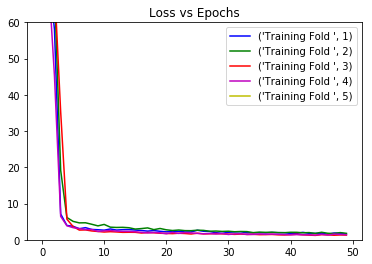

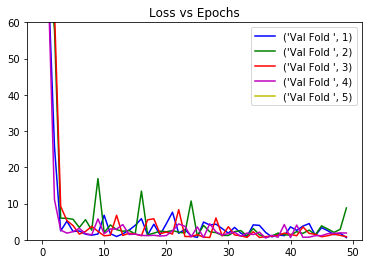

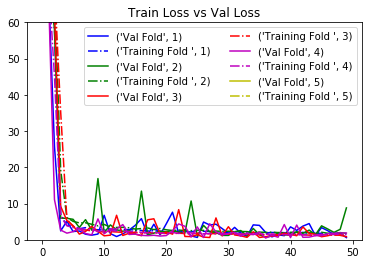

In [50]:
lossTrainPlot(model_history)
lossValPlot(model_history)
lossTrainValPlot(model_history)

In [0]:
def evaluateModel(trainX,trainY,testX,testY,model,fileImage):

  #save model2 plot as png and display summary
  plot_model(model, show_shapes = 1, to_file=fileImage)
  model.summary()

  #evaluation of the model with test data 
  print(all_scores)
  print(np.mean(all_scores))

  test_lossDense = model.evaluate(testX, testY)
  preds = model.predict(testX)

  diff = preds.flatten() - testY
  percentDiff = (diff / testY) * 100
  absPercentDiff = np.abs(percentDiff)

  mean = np.mean(absPercentDiff)
  std = np.std(absPercentDiff)

  fig, ax = plt.subplots()
  ax.scatter(testY, preds)
  ax.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'k--', lw=4)
  ax.set_xlabel('Measured')
  ax.set_ylabel('Predicted')
  plt.show()

  print("[INFO] avg. mosquito traped: {}, std mosquito trapped: {}".format((result['TOTAL'].mean()),(result['TOTAL'].std())))
  print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))
  return

In [52]:
fileImage ='DenseModel.png'
evaluateModel(testX,testY,testX,testY,model,fileImage)

NameError: ignored

In [0]:
def WeightsLayers(model):
  for layer in model.layers:
      weights = layer.get_weights()
  print(weights)
  return

In [0]:
WeightsLayers(model)

[array([[ 0.13476346],
       [ 0.75449026],
       [-0.9079459 ],
       [-0.61366546]], dtype=float32), array([0.00371771], dtype=float32)]


In [0]:
def loadBestModel(modelName):

  model = load_model(modelName)
  model.load_weights(modelName)
  print("Loaded model from disk")

  # evaluate loaded model on test data 
  # Define X_test & Y_test data first
  model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mape'])
  score = model.evaluate(testX, testY, verbose=0)
  print ("%s: %.2f%%" % (model.metrics_names[1], score[1]))
  preds = model.predict(testX)

  fig, ax = plt.subplots()
  ax.scatter(testY, preds)
  ax.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'k--', lw=4)
  ax.set_xlabel('Measured')
  ax.set_ylabel('Predicted')
  plt.show()
  return

Loaded model from disk
mean_absolute_percentage_error: 48.70%


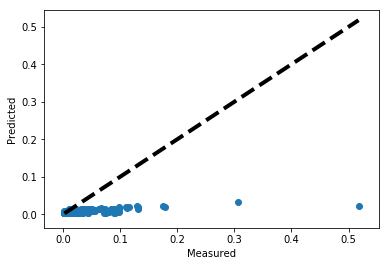

In [0]:
modelName = 'RegMos.h5'
loadBestModel(modelName)

## CNN with Images

In [0]:
model_checkpoint2 = ModelCheckpoint('RegMos2.h5', verbose=1, save_best_only=True)
def create_cnn(width, height, depth, filters=(16,32,64),regress=False):
  
  inputShape = (height, width, depth)
  chanDim = -1
  
  inputs = Input(shape=inputShape)
  
  for (i,f) in enumerate(filters):
    if i == 0:
      x = inputs
      
    x = Conv2D(f, (3,3), padding='same', kernel_regularizer='l2')(x)
    x = Activation ('relu')(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
  x = Flatten()(x)
  x = Dense(16)(x)
  x = Activation('relu')(x)
  x = BatchNormalization(axis=chanDim)(x)
  x = Dropout(0.4)(x)
  
  x = Dense(4)(x)
  x = Activation('relu')(x)
  
  if regress:
    x = Dense(1,activation='linear')(x)
    
  model = Model(inputs,x)
  opt = Adam(lr=1e-3, decay=1e-3 / 200) 
  model.compile(optimizer=opt, loss="mean_absolute_percentage_error", metrics=['mae'])
  
  return model

In [0]:
def evaluateCNN(X, y, folds=5, num_epochs=50, batch_size=16, verbose=True):
  all_scores = []
  model_history = [] 
  start = time.clock()                 

  cv = KFold(n_splits=folds, random_state=1, shuffle=True)

  train_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True,
                                   fill_mode = "nearest", zoom_range = 0.2,
                                   width_shift_range = 0.2, height_shift_range=0.2,
                                   shear_range=0.2, rotation_range=30) 

  for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    df = X_train
    train_generator = train_datagen.flow_from_dataframe(dataframe=df, directory='/content/drive/My Drive/mosquito/SatManateeAll/', 
                                              x_col="fileName", y_col="TOTAL",
                                              class_mode="other", target_size=(64, 64), 
                                              batch_size=20)
    

    model = create_cnn(64, 64, 3, regress=True)
    history2 = model2.fit_generator(train_generator,steps_per_epoch=20,epochs=num_epochs)
    
    model_history.append(history)
    val_mape,val_mae = model.evaluate(X_test, y_test, verbose=0)
    all_scores.append(val_mape)
    
  end = time.clock()
  timeDense = end-start
  #total time of training
  print("Total Time: {} ".format(timeDense)) 
  return model, model_history, all_scores

In [132]:
model2, model_history2, all_scores2 = evaluateCNN(trainX,trainY,testX,testY, model2, 50)

processing fold # 0
Epoch 1/50
20/20 [==============================] - 20s 1s/step - loss: 96.2777 - mean_absolute_error: 38.9760
Epoch 2/50
20/20 [==============================] - 20s 986ms/step - loss: 90.7276 - mean_absolute_error: 38.8607
Epoch 3/50
20/20 [==============================] - 19s 968ms/step - loss: 86.7352 - mean_absolute_error: 40.0649
Epoch 4/50
20/20 [==============================] - 19s 957ms/step - loss: 83.6106 - mean_absolute_error: 33.8637
Epoch 5/50
19/20 [===========================>..] - ETA: 0s - loss: 80.7317 - mean_absolute_error: 39.2030

KeyboardInterrupt: ignored

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 16)                480       
_________________________________________________________________
dense_44 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_45 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 5         
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________
[68.9483048837246, 1.6752924425191404, 0.8234250842366855, 1.1038821745993521, 0.9218084684180091]
14.694542610699557
9007/9007 [==============================] - 0s 35us/step


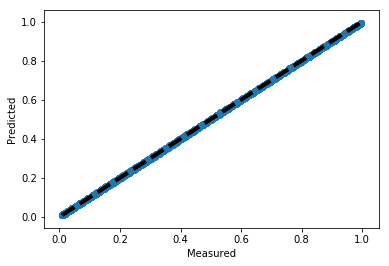

[INFO] avg. mosquito traped: 37.489165977936686, std mosquito trapped: 48.58960845404813
[INFO] mean: 0.92%, std: 1.12%


In [109]:
fileImage ='CNNModel.png'
evaluateModel(trainX,trainY,testX,testY,model,fileImage)

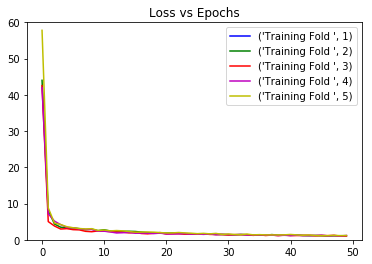

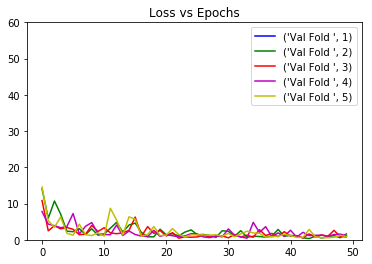

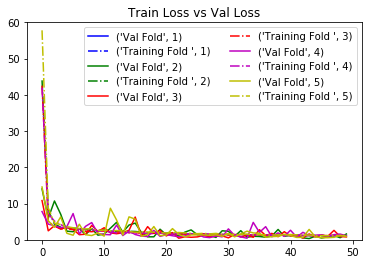

In [110]:
lossTrainPlot(model_history)
lossValPlot(model_history)
lossTrainValPlot(model_history)

In [0]:
WeightsLayers(model2)

### Transfer Learning ResNet

In [0]:
'''modelTransf2=ResNet50(weights=None,
                      include_top=True,
                      classes=1,
                      input_shape=(64,64,3))

modelTransf2 = Sequential()


modelTransf2.add(base_modelRes)
modelTransf2.add(Flatten())
modelTransf2.add(BatchNormalization())
modelTransf2.add(Dense(128, activation='linear'))
modelTransf2.add(layers.LeakyReLU(alpha=0.1))           
modelTransf2.add(Dropout(0.3))
modelTransf2.add(Dense(21, activation='softmax'))

modelTransf2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])'''

In [0]:
'''#ResNet50 Vainilla
start = time.clock() 
historyRes = modelTransf2.fit(trainImagesX, trainY, validation_data=(testImagesX, testY),epochs=200, batch_size=8)

end = time.clock()
timeRes = end-start

print("Total Time: {} ".format(timeRes)) '''

In [0]:
'''train_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=45,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=True,
        vertical_flip=True)

train_generator.fit(trainImagesX)
#ResNet with Data Augmentantion
historyResDA = modelTransf2.fit_generator(
        train_generator.flow(trainImagesX, trainY,epochs=200, batch_size=8),
        steps_per_epoch=int(2*SIZE / 32),
        epochs=256,
        validation_data=evaluate_generator.flow(testImagesX, testY), batch_size=32),
        validation_steps=128,
        verbose=2
    )'''

## Combine the models

In [0]:
model_checkpoint3 = ModelCheckpoint('RegMos3.h5', verbose=1, save_best_only=True)
def hybridModel(trainX):
  mlp = create_mlp(trainX.shape[1], regress=False)
  cnn = create_cnn(64, 64, 3, regress=False)

  combinedInput = concatenate([mlp.output, cnn.output])

  x = Dense(8, activation="relu")(combinedInput)
  x = Dense(4, activation="relu")(x)
  x = Dense(1, activation="linear")(x)

  modelF = Model(inputs=[mlp.input, cnn.input], outputs=x)

  opt = Adam(lr=1e-3, decay=1e-3 / 200)
  modelF.compile(optimizer=opt, loss="mean_absolute_percentage_error", metrics=['mae'])
  
  return modelF

In [134]:
 modelF = hybridModel(trainX)
 history3 = modelF.fit_generator(
    train_generator,
    steps_per_epoch=20,
    epochs=num_epochs)

Epoch 1/50


ValueError: ignored

In [119]:
k=5
num_val_samples = len(trainX) // k
num_epochs = 50
all_scores3 = []
model_history3 = [] 
start = time.clock()                 
for i in range(k):
  print('processing fold #', i)
  val_data = trainX[i*num_val_samples: (i+1) * num_val_samples]
  val_targets = trainY[i * num_val_samples: (i+1) * num_val_samples]
  
  #partial_train_data = np.concatenate([trainX[:i * num_val_samples], trainX[(i + 1) * num_val_samples:]], axis=1)
  #partial_train_targets = np.concatenate( [trainY[:i * num_val_samples], trainY[(i + 1) * num_val_samples:]], axis=0)
  modelF = hybridModel()
  #history3 = modelF.fit(partial_train_data, partial_train_targets,validation_data=(val_data, val_targets),epochs=num_epochs,callbacks=[model_checkpoint3, TensorBoardColabCallback(tbc)], batch_size=16, verbose=1)
  history3 = modelF.fit_generator(
    train_generator,
    steps_per_epoch=20,
    epochs=num_epochs)
  model_history3.append(history3)
  val_mape,val_mae = modelF.evaluate(trainX, testY, verbose=1)
  all_scores2.append(val_mape)
  
end = time.clock()
timeDense = end-start
#total time of training
print("Total Time: {} ".format(timeDense)) 

processing fold # 0
Epoch 1/50


ValueError: ignored

In [0]:
modelF = hybridModel()
#save model plot as png and display summary
plot_model(modelF, show_shapes = 1, to_file='HybModel.png')
modelF.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 256, 256, 16) 448         input_8[0][0]                    
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 256, 256, 16) 0           conv2d_22[0][0]                  
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 256, 256, 16) 64          activation_36[0][0]              
__________________________________________________________________________________________________
max_poolin

In [0]:

history3 = modelF.fit([trainX, trainImagesX], trainY, validation_data=([testX, testImagesX], testY),epochs=200,callbacks=[model_checkpoint3, TensorBoardColabCallback(tbc)], batch_size=16)

preds = modelF.predict([testX, testImagesX])

Train on 1416 samples, validate on 607 samples
Epoch 1/200
1416/1416 [==============================] - 8s 6ms/step - loss: 626.0858 - mean_absolute_error: 0.0541 - val_loss: 77.4509 - val_mean_absolute_error: 0.0164

Epoch 00001: val_loss improved from inf to 77.45092, saving model to RegMos3.h5
Epoch 2/200
1416/1416 [==============================] - 6s 4ms/step - loss: 82.5291 - mean_absolute_error: 0.0187 - val_loss: 87.8507 - val_mean_absolute_error: 0.0183

Epoch 00002: val_loss did not improve from 77.45092
Epoch 3/200
1416/1416 [==============================] - 6s 4ms/step - loss: 60.2530 - mean_absolute_error: 0.0178 - val_loss: 61.5160 - val_mean_absolute_error: 0.0163

Epoch 00003: val_loss improved from 77.45092 to 61.51603, saving model to RegMos3.h5
Epoch 4/200
1416/1416 [==============================] - 6s 4ms/step - loss: 58.2941 - mean_absolute_error: 0.0177 - val_loss: 55.8691 - val_mean_absolute_error: 0.0161

Epoch 00004: val_loss improved from 61.51603 to 55.8690

In [0]:
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)
 

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
 

print("[INFO] avg. mosquito traped: {}, std mosquito trapped: {}".format((result['TOTAL'].mean()),(result['TOTAL'].std())))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))




[INFO] avg. mosquito traped: 14.563519525457242, std mosquito trapped: 30.36583394682834
[INFO] mean: 53.62%, std: 28.40%


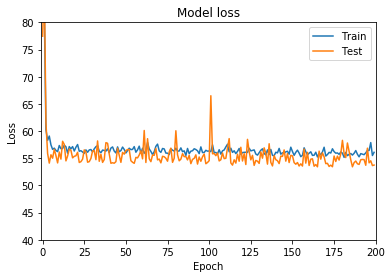

In [0]:
# Plot training & validation loss values
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.xlim(-1,200)
plt.ylim(40,80)
plt.show()

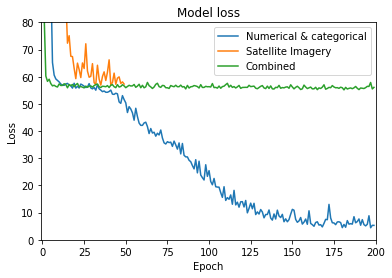

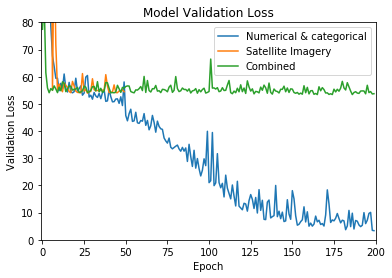

In [0]:
plt.plot(history.history['loss'], label='Numerical & categorical')
plt.plot(history2.history['loss'], label='Satellite Imagery')
plt.plot(history3.history['loss'], label='Combined')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend( loc='upper right')
plt.xlim(-1,200)
plt.ylim(0,80)
plt.show()


plt.plot(history.history['val_loss'], label='Numerical & categorical')
plt.plot(history2.history['val_loss'], label='Satellite Imagery')
plt.plot(history3.history['val_loss'], label='Combined')

plt.title('Model Validation Loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend( loc='upper right')
plt.xlim(-1,200)
plt.ylim(0,80)
plt.show()



## Sources

Source: 

[1] Cahill, Trey. (2019). Esri Story Maps: Fight the Bite, Protecting Washington, D.C. from Mosquito Borne Disease. 

[2] Giraldo-Calderón GI, Emrich SJ, MacCallum RM, Maslen G, Dialynas E, Topalis P, Ho N, Gesing S, VectorBase Consortium, Madey G, Collins FH, Lawson D. 2015. VectorBase: an updated bioinformatics resource for invertebrate vectors and other organisms related with human diseases. Nucleic Acids Research 43(Database issue):D707-13.

[3] Ehelepola, N. D. B., et al. "A study of the correlation between dengue and weather in Kandy City, Sri Lanka (2003-2012) and lessons learned." Infectious diseases of poverty 4.1 (2015): 42.

H. Ahmed E. and Moustafa M. (2016). House Price Estimation from Visual and Textual Features.In Proceedings of the 8th International Joint Conference on Computational Intelligence (IJCCI 2016)ISBN 978-989-758-201-1, pages 62-68. DOI: 10.5220/0006040700620068

https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

https://zoom.earth

In [0]:
'https://wtop.com/health-fitness/2016/06/trap-lab-dc-protects-residents-mosquito-borne-diseases/slide/1/'